In [1]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [2]:
feature_maps_array = np.load('/kaggle/input/pit-feature-maps-mobilenetv2/train_feature_maps.npy')
labels_array = np.load('/kaggle/input/pit-feature-maps-mobilenetv2/train_labels.npy')

In [3]:
labels = np.argmax(labels_array, axis=1) 
unique_labels = np.unique(labels)
num_people = len(unique_labels)

num_samples, height, width, channels = feature_maps_array.shape
feature_maps_reshaped = feature_maps_array.reshape(num_samples, -1)

pca = PCA(n_components=128)
feature_maps_reduced = pca.fit_transform(feature_maps_reshaped)

k_values = range(2, 17) 
results = {}

for label in unique_labels:
    person_indices = np.where(labels == label)[0] 
    person_feature_maps = feature_maps_reduced[person_indices]
    
    best_k = 2
    best_score = float('inf')
    
    for k in k_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=10)
        kmeans.fit(person_feature_maps)
        
        distances = kmeans.transform(person_feature_maps)
        min_distances = np.min(distances, axis=1)
        avg_distance = np.mean(min_distances)
        
        if avg_distance < best_score:
            best_score = avg_distance
            best_k = k
    
    results[label] = best_k

avg_distances = {}
for k in k_values:
    total_distance = 0
    count = 0
    
    for label in unique_labels:
        person_indices = np.where(labels == label)[0]
        person_feature_maps = feature_maps_reduced[person_indices]
        
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=10)
        kmeans.fit(person_feature_maps)
        
        distances = kmeans.transform(person_feature_maps)
        min_distances = np.min(distances, axis=1)
        total_distance += np.mean(min_distances)
        count += 1
    
    avg_distances[k] = total_distance / count

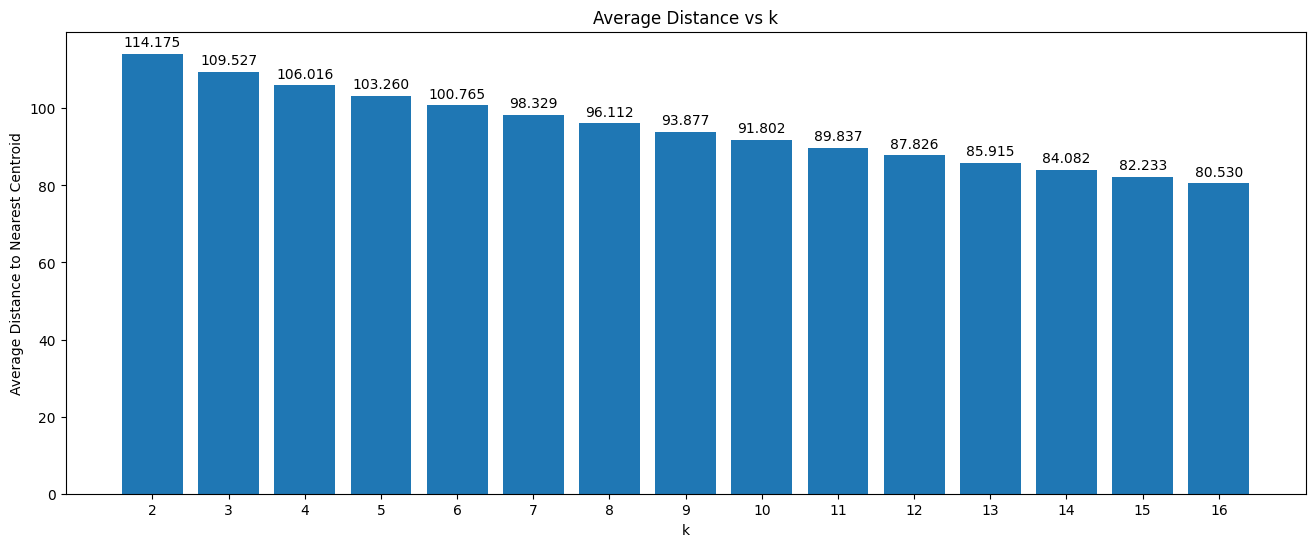

In [4]:
plt.figure(figsize=(16, 6)) 
bars = plt.bar(avg_distances.keys(), avg_distances.values())
plt.xlabel('k')
plt.ylabel('Average Distance to Nearest Centroid')
plt.title('Average Distance vs k')

plt.bar_label(bars, fmt='%.3f', padding=3)  
plt.xticks(list(avg_distances.keys()))

plt.show()

In [5]:
best_k = min(avg_distances, key=avg_distances.get)
print(f"Best k: {best_k}")

Best k: 16


In [6]:
all_centroids = []

for label in unique_labels:
    person_indices = np.where(labels == label)[0]
    person_feature_maps = feature_maps_reduced[person_indices]
    
    kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=1024, n_init=10)
    kmeans.fit(person_feature_maps)
    
    all_centroids.append(kmeans.cluster_centers_)

all_centroids = np.concatenate(all_centroids, axis=0) 
print("Shape of all_centroids:", all_centroids.shape)
np.save('/kaggle/working/all_centroids.npy', all_centroids)

Shape of all_centroids: (7808, 128)


In [7]:
distance_vectors = []
for feature_map in feature_maps_reduced:
    distances = np.linalg.norm(all_centroids - feature_map, axis=1)  
    distance_vectors.append(distances)

distance_vectors = np.array(distance_vectors)

In [8]:
print("Shape of distance_vectors:", distance_vectors.shape)

Shape of distance_vectors: (31921, 7808)


In [9]:
np.save('/kaggle/working/distance_vectors_train.npy', distance_vectors)